# Connected Component Labelling

Este notebook utiliza la técnica de etiquetado de componentes conectados para poder extraer features morfológicos de los granos de arroz.

In [1]:
# General
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import random
from collections import Counter

# Imagen
import cv2
from skimage import measure

# Normalización
from sklearn.preprocessing import StandardScaler

# Reducción de Dimensionalidad
from umap import UMAP
from sklearn.decomposition import PCA

# Kmeans
from sklearn.cluster import KMeans

# Metricas
from sklearn.metrics import rand_score, adjusted_rand_score


# warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

/home/nachengue/fundar/python_projects/unsupervised-rice-image-segmentation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-10 12:18:11.688132: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-10 12:18:11.689330: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 12:18:11.734774: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 12:18:11.737563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized t

In [27]:
import re

def get_labels_and_paths(input_folder):
   return sorted([(dp.split("/")[1],os.path.join(dp, f)) for dp, dn, filenames in os.walk('input') for f in filenames if os.path.splitext(f)[1] == '.jpg'])

def img_to_numpy(path, grayscale=False): 
    img = cv2.imread(filename=path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def binarizado(img, thresh=None):
    img_binary = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 
                               thresh, 255, cv2.THRESH_BINARY)
    return img_binary[1]


def cross_tab(Labels_orig, Labels_clust):
    '''crea matriz de confusión para evaluar etiquetado
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo'''
    tmp = pd.DataFrame({'Labels_orig': Labels_orig, 'Labels_clust': Labels_clust})
    ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
    rand = rand_score(Labels_orig, Labels_clust)
    arand= adjusted_rand_score(Labels_orig, Labels_clust)
    print(f'RAND score={rand:.4f}, Ajusted RAND={arand:.4f}, cantidad_de_muestras={len(Labels_orig):,d}')
    return ct


def features_morfologicos(imagen_binaria, properties=None):
    label_img = measure.label(imagen_binaria)
    props_table = measure.regionprops_table(label_img, properties=properties)
    return props_table

def generate_features(class_name, filepath, feature_list=None):
    img = img_to_numpy(filepath)
    img_binary = binarizado(img, thresh=100)
    props_table = features_morfologicos(imagen_binaria=img_binary, properties=feature_list)
    props_table['class_name'] = class_name
    num_id = re.search("\d+", filepath.split("/")[-1])[0]
    props_table['image_id'] = f"{class_name.lower()} ({num_id}).jpg"
    return pd.DataFrame(props_table)

In [4]:
INPUT_FOLDER = "input/"
labels_and_paths = get_labels_and_paths(input_folder=INPUT_FOLDER)
input_paths = np.array([x[1] for x in labels_and_paths])
labels = np.array(x[0] for x in labels_and_paths) 

label_names = pd.DataFrame(labels_and_paths, columns=["name","file"])
label_names['label'] = label_names['name'].map({"Arborio":0,
                                                "Basmati":1,
                                                "Ipsala":2,
                                                "Jasmine":3,
                                                "Karacadag":4})

In [6]:
# Contar las clases
class_counts = Counter(item[0] for item in labels_and_paths)

# Calcular la cantidad mínima de elementos por clase
min_count = 1

total_samples = min_count * len(class_counts)

# Crear una lista de elementos por clase
grouped_data = {key: [item for item in labels_and_paths if item[0] == key] for key in class_counts.keys()}

# Tomar una muestra estratificada
stratified_sample = []
for key, group in grouped_data.items():
    random.shuffle(group)  # Mezcla los elementos para obtener una muestra aleatoria
    stratified_sample.extend(group[:min_count])  # Agrega la misma cantidad de elementos por clase

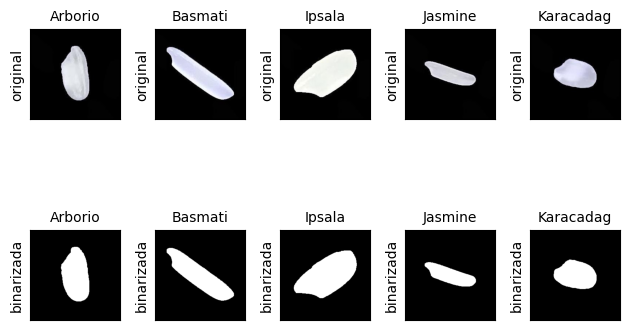

In [30]:
fig, axs = plt.subplots(ncols=len(stratified_sample),nrows=2, sharey=True, sharex=True)
axs1, axs2 = axs.reshape(2,-1)
for (label,path),ax1,ax2 in zip(stratified_sample, axs1, axs2):
    img = img_to_numpy(path=path)
    ax1.imshow(img)
    ax1.set_title(f"{label}", fontsize=10)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel("original")
    img_binary = binarizado(img, thresh=100)
    ax2.imshow(img_binary, cmap="gray")
    ax2.set_title(f"{label}", fontsize=10)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_ylabel('binarizada')

plt.tight_layout()
plt.show()



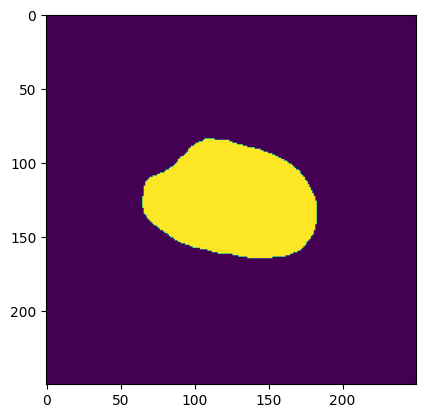

In [48]:
label_im = measure.label(img_binary)
regions = measure.regionprops(label_image=label_im)
plt.imshow(label_im)
plt.show()

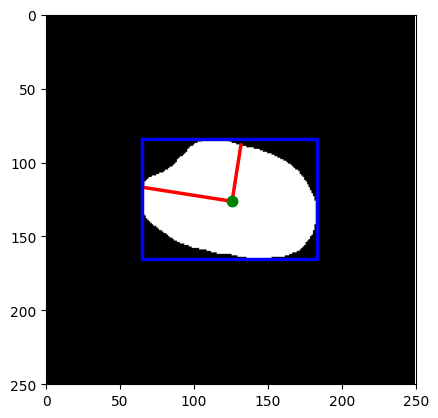

In [43]:
fig, ax = plt.subplots()
ax.imshow(img_binary, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 250, 250, 0))
plt.show()

In [46]:
properties = ['area','eccentricity','perimeter','centroid',
              'orientation','axis_major_length','axis_minor_length']

props_table = measure.regionprops_table(label_im, properties=properties)

pd.DataFrame(props_table)

,area,eccentricity,perimeter,centroid-0,centroid-1,orientation,axis_major_length,axis_minor_length
0,7124.0,0.760914,330.735065,126.240455,125.803622,1.415395,118.841876,77.110876


In [28]:
features_list = ['area','eccentricity','perimeter',
              'orientation','axis_major_length','axis_minor_length']

X = pd.DataFrame()
for class_name, path in tqdm(labels_and_paths):
    x = generate_features(class_name=class_name, filepath=path, feature_list=features_list)
    X = pd.concat([X, x], axis=0)


100%|██████████| 75000/75000 [05:31<00:00, 226.49it/s]


In [36]:
X.to_csv("output/datasets/features_morfologicos.csv.gz", index=False)

In [65]:
# labels = X.class_name.to_list()
# features = X.loc[:, features_list].to_numpy()

(75000, 6)

In [ ]:
# Uso PCA

# n_components = features.shape[1]

# scaler = StandardScaler()
# scaled = scaler.fit_transform(features)

# pca = PCA(n_components=n_components)
# scaled_pca = pca.fit(scaled)
# Xpca = pca.transform(scaled)
# exp_var = scaled_pca.explained_variance_ratio_



In [ ]:
# Uso UMAP

# umap = UMAP(
#     n_neighbors=30,
#     min_dist=0.0,
#     n_components=2
# )

# # Hago el fuzzy clustering
# standard_embedding = umap.fit_transform(scaled)


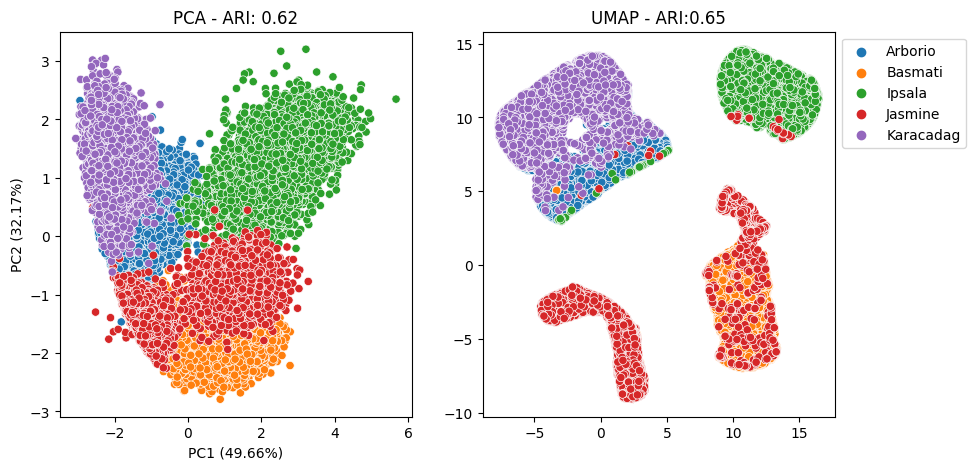

In [86]:
# kmeans = KMeans(n_clusters=5, n_init='auto')

# # Kmeans con salida PCA
# kmeans.fit(Xpca)
# kmeans_pca_labels = kmeans.labels_
# ari_pca = adjusted_rand_score(labels_true=labels, labels_pred=kmeans_pca_labels)

# # Kmeans con salida UMAP
# kmeans.fit(standard_embedding)
# kmeans_umap_labels = kmeans.labels_
# ari_umap = adjusted_rand_score(labels_true=labels, labels_pred=kmeans_umap_labels)


# fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# g1 = sns.scatterplot(x = Xpca[:,0], y = Xpca[:,1], hue = labels, ax=axs[0])
# axs[0].set_xlabel(f"PC1 ({'{0:.2f}%'.format(exp_var[0]*100)})")
# axs[0].set_ylabel(f"PC2 ({'{0:.2f}%'.format(exp_var[1]*100)})")
# axs[0].set_title(f"PCA - ARI: {'{0:.2f}'.format(ari_pca)}")
# axs[0].get_legend().remove()

# g2 = sns.scatterplot(x = standard_embedding[:,0], y = standard_embedding[:,1], hue = labels, ax= axs[1])
# axs[1].set_title(f"UMAP - ARI:{'{0:.2f}'.format(ari_umap)}")
# sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))

# plt.show()